In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
sns.set_style()

#### Import datasets

In [2]:
bulk_fluo = pd.read_csv('datasets/bulk_fluo_induction.csv')
fluo = pd.read_csv('datasets/fluo_induction.csv')
od = pd.read_csv('datasets/od_induction.csv')

In [3]:
def parse_minutes(x):
    spl = x.split(' ')
    hours = int(spl[0]) * 60
    mins = int(spl[2]) if spl[2] != '' else 0
    return hours + mins

def transpose_data(df_raw):
    df = df_raw.copy()
    df = df.transpose().reset_index()
    df['time'] = df['index'].apply(parse_minutes)
    df = df.set_index('time')
    df = df.drop('index', axis=1)
    return df

In [4]:
cols = bulk_fluo['short_name'].dropna().unique()
cols

array(['e11x32STPhoRadA', 'e15x32NpuSspS2', 'e16x33NrdA2', 'e20x32gp411',
       'e32x30SspGyrB', 'e34x30MjaKlbA', 'e38x32gp418', 'e41x32NrdJ1',
       'e42x32STIMPDH1'], dtype=object)

Sort by 'ind1_lvl' and 'ind2_lvl' to make sure the ordering/color coding is correct.

In [5]:
#make sure the ordering/color coding is correct
bulk_fluo = bulk_fluo.sort_values(['ind1_lvl', 'ind2_lvl'])
od = od.sort_values(['ind1_lvl', 'ind2_lvl'])

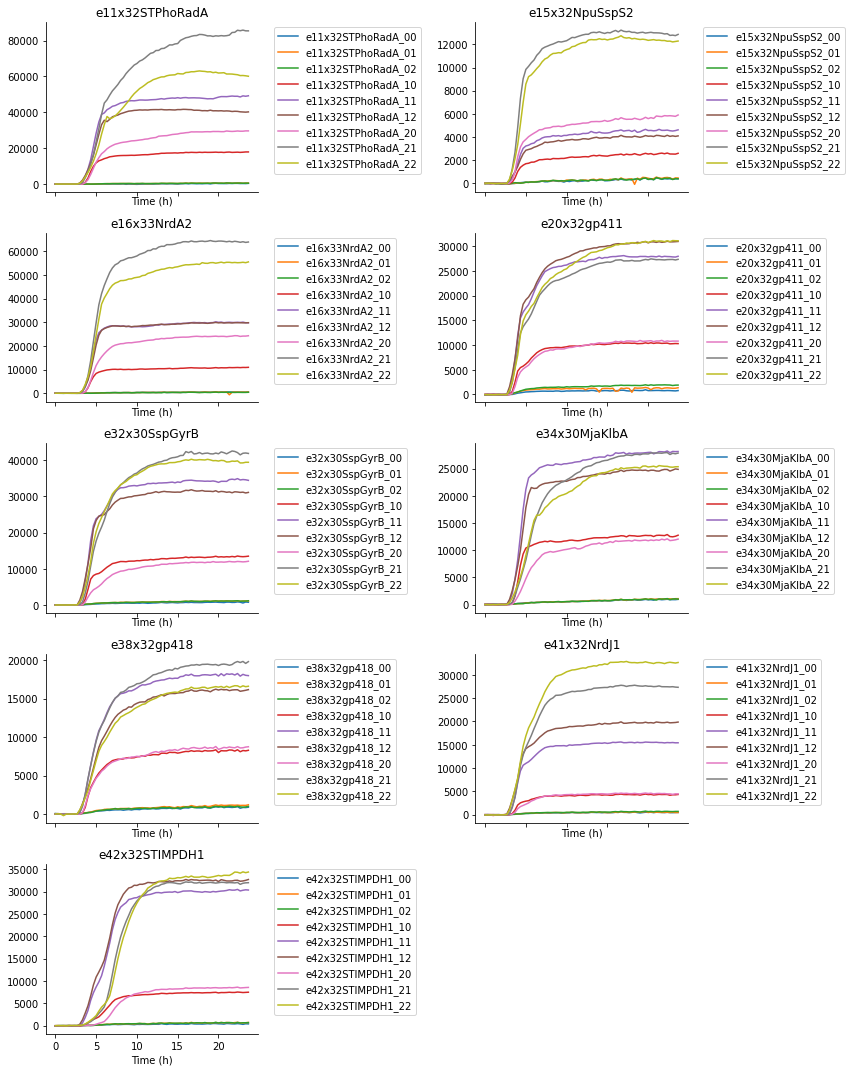

In [6]:
def plot_data(data, cols, num_row, num_col):
    f, axs = plt.subplots(num_row, num_col, sharex=True, sharey=False, figsize=(12, num_row*3))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(cols):
            gate = data[data['short_name']==cols[i]].dropna()
            gate['induction_level'] = gate['short_name'] + '_' + gate['ind1_lvl'].astype(str) + gate['ind2_lvl'].astype(str)
            gate = gate.iloc[:,4:].set_index('induction_level')
            gate = transpose_data(gate)
            cs = gate.columns.tolist()
            for c in cs:
                ax.plot(gate.index/60, gate[c], label=c)
            ax.set_title(cols[i])
            ax.set_xlabel('Time (h)')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='best')
        else:
            ax.set_visible(False)
    plt.tight_layout()
    sns.despine()
    
#plot fluorescence data
plot_data(bulk_fluo, cols, 5, 2)

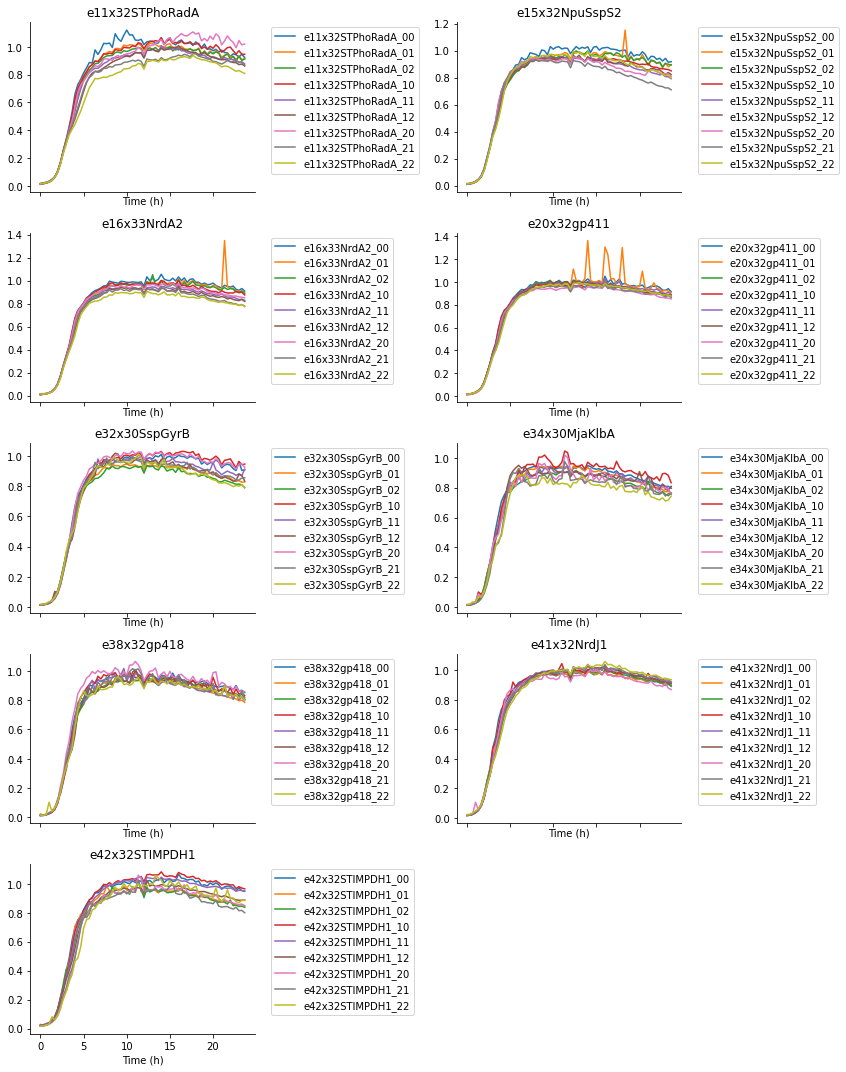

In [7]:
#plot od data
plot_data(od, cols, 5, 2)

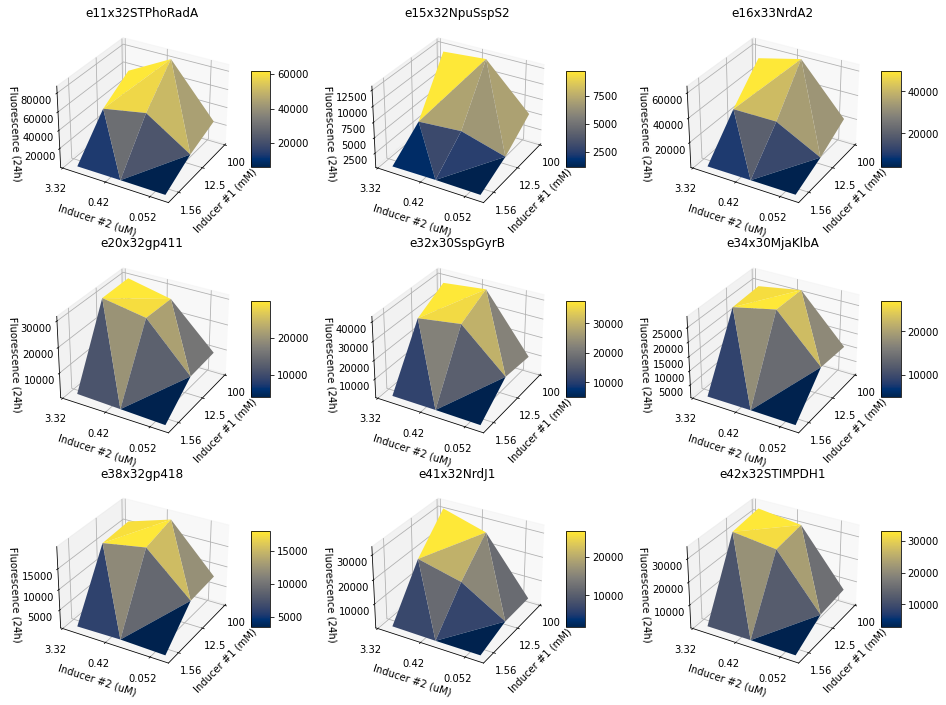

In [9]:
def plot_3d(data, cols, num_row, num_col):
    
    fig = plt.figure(figsize=[16, 12])
    for i in range(len(cols)):
        
        gate = bulk_fluo[bulk_fluo['short_name']==cols[i]].dropna()
        gate['induction_level'] = gate['short_name'] + gate['ind1_lvl'].astype(str) + gate['ind2_lvl'].astype(str)
        data = gate[['ind1_lvl', 'ind2_lvl', '23 h 40 min']]
        
        plt.subplot(num_row, num_col, (i+1), projection='3d')
        ax = fig.gca(projection='3d')
        surf = ax.plot_trisurf(data['ind1_lvl'], data['ind2_lvl'], data['23 h 40 min'], cmap='cividis')
        fig.colorbar(surf, shrink=0.5, aspect=5)
        
        ax.w_xaxis.set_ticks(np.arange(3) + 0.5/2.)
        ax.w_yaxis.set_ticks(np.arange(3) + 0.5/2.)
        ax.w_xaxis.set_ticklabels([1.56, 12.5, 100])
        ax.w_yaxis.set_ticklabels([0.052, 0.42, 3.32])

        # Labeling the 3 dimensions
        ax.set_xlabel('Inducer #1 (mM)')
        ax.set_ylabel('Inducer #2 (uM)')
        ax.set_zlabel('Fluorescence (24h)')
        ax.set_title(cols[i])
        ax.view_init(30, -150)
        
    plt.show()
    
plot_3d(bulk_fluo, cols, 3, 3)

<ipython-input-10-bd77ad26544b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pvt['ind1_lvl'] = data_pvt['ind1_lvl'].map(ind1_map)
<ipython-input-10-bd77ad26544b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pvt['ind2_lvl'] = data_pvt['ind2_lvl'].map(ind2_map)


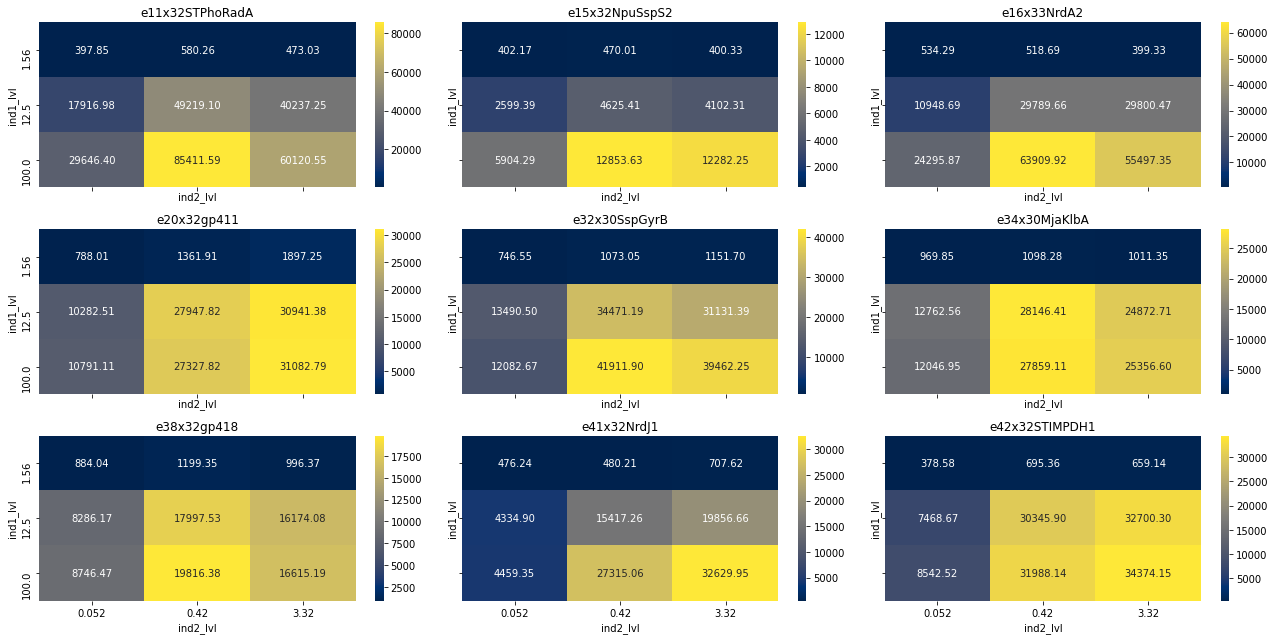

In [10]:
ind1_map = {0: 1.56, 1: 12.5, 2: 100}
ind2_map = {0: 0.052, 1: 0.42, 2: 3.32}

def plot_heatmap(data_raw, cols, num_row, num_col):
    
    data = data_raw.copy()
    f, axs = plt.subplots(num_row, num_col, sharex=True, sharey=True, figsize=(18, num_row*3))
    axr = axs.ravel()
    
    for i, ax in enumerate(axr):
        if i < len(cols):
            data_pvt = data[data['short_name']==cols[i]]
            data_pvt['ind1_lvl'] = data_pvt['ind1_lvl'].map(ind1_map)
            data_pvt['ind2_lvl'] = data_pvt['ind2_lvl'].map(ind2_map)
            gate = data_pvt.pivot(index='ind1_lvl', columns='ind2_lvl', values='23 h 40 min')
            sns.heatmap(gate, cmap='cividis', annot=True, fmt='.2f', ax=ax)
            ax.set_title(cols[i])
        
        else:
            ax.set_visible(False)
    plt.tight_layout()
    plt.show()
    
plot_heatmap(bulk_fluo, cols, 3, 3)